In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as pl
%matplotlib inline
from pylab import mpl, plt 
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300 
mpl.rcParams['font.family'] = 'serif'

### 1. Import data

In [3]:
raw = pd.read_csv('Eikon EOD Data.csv',
                  index_col = 0, parse_dates = True).dropna()

In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  2516 non-null   float64
 1   MSFT.O  2516 non-null   float64
 2   INTC.O  2516 non-null   float64
 3   AMZN.O  2516 non-null   float64
 4   GS.N    2516 non-null   float64
 5   SPY     2516 non-null   float64
 6   .SPX    2516 non-null   float64
 7   .VIX    2516 non-null   float64
 8   EUR=    2516 non-null   float64
 9   XAU=    2516 non-null   float64
 10  GDX     2516 non-null   float64
 11  GLD     2516 non-null   float64
dtypes: float64(12)
memory usage: 255.5 KB


In [5]:
raw.head(3)

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.95,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.00,47.71,109.80
2010-01-05,30.625684,30.96,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.65,48.17,109.70
2010-01-06,30.138541,30.77,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.50,49.34,111.51


Considering gold price in USD (end-of-day closing prices):

In [7]:
data = pd.DataFrame(raw['XAU='])

In [9]:
data.rename(columns = {'XAU=': 'price'}, inplace = True)

In [10]:
data.head(3)

,price
Date,
2010-01-04,1120.00
2010-01-05,1118.65
2010-01-06,1138.50


In [11]:
# calculate log returns 
data['returns'] = np.log(data['price'] / data['price'].shift(1))

In [12]:
data.head(3)

,price,returns
Date,,
2010-01-04,1120.00,NaN
2010-01-05,1118.65,-0.001206
2010-01-06,1138.50,0.017589


### 2. Simple time-series momentum strategy

Strategy: buy the stock if the last return was positive and sell it if it was negative.

=> just take the sign of the last available return as the market position.

=> the strategy does significantly underperform the base instrument:

In [13]:
data['position'] = np.sign(data['returns'])

In [14]:
data.head(3)

,price,returns,position
Date,,,
2010-01-04,1120.00,NaN,NaN
2010-01-05,1118.65,-0.001206,-1.0
2010-01-06,1138.50,0.017589,1.0


In [15]:
# calculate the strategy's log returns
data['strategy'] = data['position'].shift(1) * data['returns']

In [16]:
data.head(3)

,price,returns,position,strategy
Date,,,,
2010-01-04,1120.00,NaN,NaN,NaN
2010-01-05,1118.65,-0.001206,-1.0,NaN
2010-01-06,1138.50,0.017589,1.0,-0.017589


<AxesSubplot:xlabel='Date'>

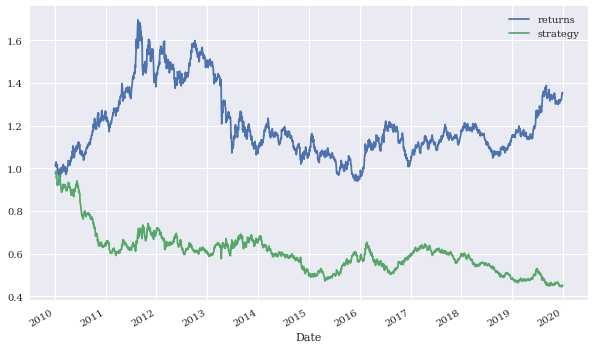

In [17]:
# calculate cumulative (grosss) returns (remove log)
data[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize = (10, 6))

### 3. Generalize the time-series momentum strategy 

Using a rolling time window to generalize the time series momentum strategy to more than just the last return.

Using the average of the last 3 returns to generate the signal for the positioning.

=> The strategy in this case does much better:

In [19]:
data.head(3)

,price,returns,position,strategy
Date,,,,
2010-01-04,1120.00,NaN,NaN,NaN
2010-01-05,1118.65,-0.001206,-1.0,NaN
2010-01-06,1138.50,0.017589,1.0,-0.017589


In [30]:
data['position'] = np.sign(data['returns'].rolling(3).mean())

In [31]:
data['strategy'] = data['position'].shift(1) * data['returns']

In [32]:
data.head(5)

,price,returns,position,strategy
Date,,,,
2010-01-04,1120.00,NaN,NaN,NaN
2010-01-05,1118.65,-0.001206,NaN,NaN
2010-01-06,1138.50,0.017589,NaN,NaN
2010-01-07,1131.90,-0.005814,1.0,NaN
2010-01-08,1136.10,0.003704,1.0,0.003704


<AxesSubplot:xlabel='Date'>

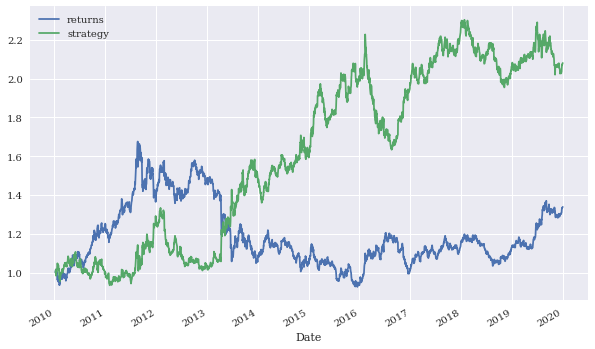

In [33]:
data[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize = (10, 6))

If using last two returns => gross performance worse off => sensitive to the time window parameter:

In [34]:
# generate market signals using the last 2 returns 
data['position'] = np.sign(data['returns'].rolling(2).mean())

In [35]:
# calculate the strategy log returns
data['strategy'] = data['position'].shift(1) * data['returns']

In [37]:
data.head(5)

,price,returns,position,strategy
Date,,,,
2010-01-04,1120.00,NaN,NaN,NaN
2010-01-05,1118.65,-0.001206,NaN,NaN
2010-01-06,1138.50,0.017589,1.0,NaN
2010-01-07,1131.90,-0.005814,1.0,-0.005814
2010-01-08,1136.10,0.003704,-1.0,0.003704


<AxesSubplot:xlabel='Date'>

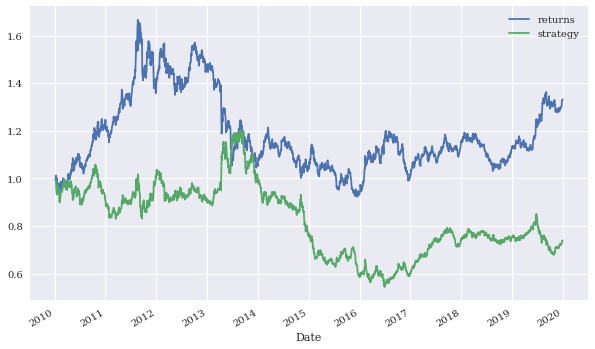

In [28]:
# compare the strategy return versus the benchmark return 
data[['returns', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize = (10, 6))

=> strategy's gross performance worse off